# Building and training a simple neural network

In this notebook we will construct the neural net seen in the videos by Sanderson. For this, we will use the python library [PyTorch](https://pytorch.org/) and the [MINST](http://deeplearning.net/data/mnist/) dataset discussed in the video. This notebook is based loosly on a [PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard.

Run the cell below to import all of the python packages we will require in this notebook.

In [228]:
from pathlib import Path # internal python library for managing file paths
import requests # used to doqload files using web requests
import pickle
import gzip # used to unzip files
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
from torch import nn
import copy

# Getting and displaying the MINST dataset

We will start by creating a folder on Google's servers to hold the data in the MINT dataset.

In [7]:
data_path = Path("data")
path = data_path/"mnist" # this defines the file path as data/mnist
path.mkdir(parents=True, exist_ok=True) # this creates the folders "data" and "data/mnist"

Now we will download the data (only if we haven't downloaded it before), and save it in the folder we created in the last code cell.

In [216]:
data_url = "https://github.com/pytorch/tutorials/raw/main/_static/"
data_filename = "mnist.pkl.gz"

if not (data_path / data_filename).exists():
  content = requests.get(data_url + data_filename).content
  (data_path/data_filename).open("wb").write(content)

The data is stored as a numpy array. It was saved using the python library "pickle" in a python-specific data format. In the following code cell we will unpack the data and then store the numpy arrays in the following variables:

- `image_train`: This is a numpy array that contains all of the images in the training dataset. We will use this to train our neural network.
- `label_train`: This is a numpy array that contains the corresponding label for each image in the training dataset. We will use this to train our neural network.
- `image_valid`: This is a numpy array that contains all of the images in the validation dataset. After training our network we will use this to evaluate how well our model does on data it has not seen before.
- `label_valid`: This is a numpy array that contains the corresponding label for each image in the validation dataset. After training our network we will use this to evaluate how well our model does on data it has not seen before.

In [27]:
with gzip.open((data_path / data_filename).as_posix(), "rb") as unpacked_data:
  ((image_train, label_train), (image_valid, label_valid), _) = pickle.load(unpacked_data, encoding="latin-1")

Now that the data is loaded and unpacked, we can display some of the data. Because the data is stored in a single 784 element array, we need to re-shape it into the 28x28 black and white image. This is done using the `reshape(x_pixels, y_pixels)` function.

Try running the code below loading in a differnt image by changing the `elem = 0` line. **What is the first element of the array `image_train` that is a `9`?**

The image is an example of the number 5


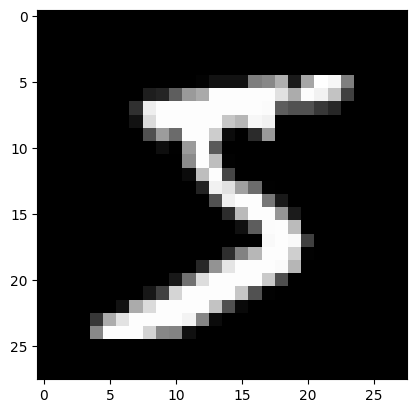

In [217]:
elem = 0
print(f"The image is an example of the number {label_train[elem]}")
image = image_train[elem].reshape((28, 28))
plt.imshow(image, cmap="gray")
plt.show()

---
# Building a neural network


There are a number of components that go into building a neural network, all of which were discussed in the two videos by Sanderson. The primary components are listed below and we will work on building each of them piece by piece:

- **Cost function**: This is the function we are trying to minimize. In our case, it is the squared difference between the predictions of the model (the value of the neurons in the final layer) and the expected value.
- **Activation function**: This is the sigmoid or logistic function we use to "squish" the value of each neuron into a value between 0 and 1.
- **Network (or model) structure**: This will define the different layers of the network. In our case, we have an input layer, two hidden layers each with 16 neurons, and one output layer.

## Defining the cost function

To start we will define the cost function. We will use the same cost function that was used by Sanderson in the video. Our cost function is the sum of the square of the difference between the predicted and actual value for each nueron in the output layer. This can by done using existing functions in PyTorch. `MSELoss` is a function that stands for "Mean squared error loss." What Sanderson (and I) are calling the "cost function" is most often called the "loss function" in the world of machine learning, hence the word loss in the name. Regardless of its name, it is the same as the square of the residuals we saw when studying empirical models. It is the function that we are trying to minimize.

While we are at it, we will also define a function to get the target. Or what we expect the model to output (a vector of all zeros, except for the element that corresponds to the digit in the image).

In [152]:
# Define the cost function that takes in the model prediction (input) and the expected output by the model (target)
def cost_func(input, target):
   cost = torch.nn.MSELoss(reduction='sum')
   return cost(input, target)

# Define a function that takes in a digit (0-9) and creates the corresponding model target
def get_target(digits):
  target = F.one_hot(torch.tensor(digits), 10)
  return target


### Testing the cost function

Let's test if our cost function is working as we would expect. We will start by creating a random [tensor](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor) (essentially just an `np.array` or normal python list but with some additional information needed by PyTorch). Because there are 10 possible digits, we will create a tensor with 10 elements.

In [129]:
# Create a tensor to act as our output with random values
out = torch.rand(10)
print(f"Our simulated random output from the model is {out.numpy()}.")

Our simulated random output from the model is [0.23718637 0.77210295 0.21110773 0.14786804 0.8318654  0.18643737
 0.7724193  0.09676838 0.15480387 0.44118607].


Next we will create the target tensor. This should be a tensor where every element is 0 except for the element that corresponds to the digit being displayed. The code below displays the digit and prints the corresponding target tensor. You can play around with which element we are displaying and see how the target tensor changes.

The image is an example of the number 5
Our expected output from the model is [0 0 0 0 0 1 0 0 0 0].


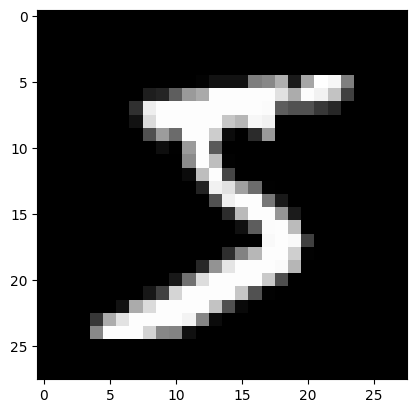

In [141]:

elem = 0 # Element in the training set to display
print(f"The image is an example of the number {label_train[elem]}")

# Create a tensor representing the true value. All values are zero except for the element corresponding to the correct digit
tar = get_target(label_train[elem])
print(f"Our expected output from the model is {tar.numpy()}.")

# Display the image corresponding to the prediction tensor
image = image_train[elem].reshape((28, 28))
plt.imshow(image, cmap="gray")
plt.show()


Now we can actually test our cost function. **Does the value of the cost function make sense given the predicted and target tensors?**

In [142]:
print(f"Predicted tensor: {out.numpy()}")
print(f"Target tensor: {tar.numpy()}.")
cost = cost_func(out,tar)
print(f"The value of the cost function is {cost.item():.6f}")

Predicted tensor: [0.23718637 0.77210295 0.21110773 0.14786804 0.8318654  0.18643737
 0.7724193  0.09676838 0.15480387 0.44118607]
Target tensor: [0 0 0 0 0 1 0 0 0 0].
The value of the cost function is 2.897321


## Defining the activation function

Now we need to define the activation function, or how we "squish" the value in each neuron . In this case we will use the sigmoid function:

$$\frac{1}{1+e^{-x}}$$

 Like the cost function, this can be done using existing functions in PyTorch

In [82]:
activation_func = F.sigmoid

### Testing the activation function

Let's run through a few examples testing the activation function.

In [83]:
input = torch.tensor([0,100,-100])
print(f"sigmoid of {input} is {activation_func(input)}")

sigmoid of tensor([   0,  100, -100]) is tensor([0.5000, 1.0000, 0.0000])


## Defining the model

The final step is now creating the shape of the model. At first we will emulate the model that Sanderson used in his video. That model consisted of one input layer, two hidden layers, and one output layer. The layers had the following sizes:

- Input layer: 728 elements, each corresponding to the brightness of a single pixel in an image.
- Hidden layer 1: 16 elements
- Hidden layer 2: 16 elements
- Output layer: 10 elements, each one corresponding to how sure the model is that the input image is a particular digit.

We will create a new python class to represent our model based on an existing PyTorch class. Most of the details here are not important. The comments in the code below will highlight the important bits for us (what are the sizes of the different layers, and where are they created).

In [102]:
class NN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(784,16) # Our input layer has 784 neurons and our first hidden layer has 16 elements
    self.hidden2 = nn.Linear(16,16) # Our second hidden layer has 16 inputs and 16 outputs
    self.output = nn.Linear(16,10) # Our output layer has 16 inputs and 10 outputs

  def forward(self, xb):
    # xb is the value of all the neurons at the current layer.
    # At the start it is a tensor with 784 elements

    # Do the matrix multiplication and then take the sigmoid of each element in the first hidden layer.
    xb = activation_func(self.hidden1(xb))
    # xb is now a tensor with 16 elements

    # Do the matrix multiplication and then take the sigmoid of each element in the second hidden layer.
    xb = activation_func(self.hidden2(xb))
    # xb is now a tensor with 16 elements

    # Do the matrix multiplication and then take the sigmoid of each element in the output layer.
    xb = activation_func(self.output(xb))
    # xb is now a tensor with 10 elements

    return xb

**How could we modify the model above to add a third hidden layer with 16 neurons (do not actually modify the code)?**

### Testing the model

The code cell below will create a new version of our model, randomly setting the weights and biases each time the code is run. We will then grab the first element in our training set (the 5 we have seen multiple times) and run the image through the model. Finally, we print the output (prediction) of the model, what the model should give, and the value of the cost function.

**Does the model prediction change each time you run the code cell? Why?**

In [113]:
model = NN_Model() # This will default to creating a model with random weights and biases.

# We will grab the first image in the training set
input = torch.tensor(image_train[0])

# and now create the corresponding target
target = get_target(label_train[0])

# Run the model on the input
output = model(input)
print(f"The ouput of the untrained model is {output.detach().numpy()}.")
print(f"The target value is {target.numpy()}.")
print(f"The cost function is {cost_func(output, target)}.")


The ouput of the untrained model is [0.4982348  0.49041155 0.52781147 0.6438965  0.4388425  0.54433864
 0.53198075 0.53223586 0.5421729  0.50463563].
The target value is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.].
The cost function is 2.697026252746582.


That's it! You have now sucessfully built and ran a neural network for classifying hand written digits!! There's just one glaring problem, it does a terrible job. Our next step will be to train the model, or adjust all of the 13000 values that make up the model until our model is actually useful for identifying digits.

# Training the model

It's now time to train the model. Because this is a process we will likely want to do numerous times, we will define a python function for it. The training process involves the following steps (**can you map these steps to the code below?**)

1. We are intrested in studying how well the model can identify digits as we continue to train the model. As a result, we will create empty lists to save how well the model is doing after each iteration of training using all of the data (or **epoch**). We will also save a copy of the model after each epoch.
2. If we were doing a pure gradient descent method, we would evaluate the model for every instance of the training set, then apply the gradient descent method to adjust all of the parameters in our model. This would be unreasonably slow and computationally infeasible. Instead, we only run the model on some small subset of data (a **batch**). After each batch, we then apply the gradient descent method. As a result we apply the gradient descent method many times in a single epoch. If you're intrested in more details for why this works and why it's a good idea, check out the [third video in Sanderson's series](https://www.youtube.com/watch?v=Ilg3gGewQ5U). Trusting this is a good idea that works, for each batch we then:
  1. Get the start and end indices of the batch we are processing.
  1. Get the subset of data (`xb`) to run through the model to get our predictions from the output layer (`pred`). Get the subset of labels (`yb`) to compare to our predicitons.
  1. Evaluate the cost function for all of the training examples in our batch
  1. Run backpropagation to calculate the gradient of the cost function (and how much we should update each parameter).
  1. Adjust each parameter value in the model based on the value calculated in the previous step.
  1. Reset internal variables used to calcualte the gradient of the batch.
1. Once we have completed this for every batch in an epoch we then evaluate the average cost function for the entrire training set and store this in our list to return to the user.
1. Repeat steps 2 and 3 until we have trained the model on all of the data multiple times.

The code below implements these steps. In fact, it is general enough that we can change the structure of the model, or the data, and still be able to use the same training function. In this class, any time we need to train a model, I will give you this function or a version similar to it.

In [231]:
# We will define a function for training out model:
# epochs is the number of times we pass over the complete training set.
# batch_size is how many training examples to combine before updating the model parameters
# learning_rate controls how large of a step we take each time we update the model parameters
# data_train is the list of images we are training on (the entirety of this dataset corresponds to a single epoch)
# label_train is the list of labels corresponding to the images in data_train
# model is the model we are training

# The function will return a list containing the average cost function after each epoch
def train_model(epochs, batch_size, learning_rate, data_train, label_train, model):

  # Create lists to return
  epoch_data = []
  cost_train = []
  models = []

  # Create the optimizer to perform the gradient descent
  opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # We will repeat the training process multiple times, printing the current average of the cost function after each epoch
  for epoch in range (epochs):

    # Each iteration of this loop will evaluate the model
    # on a subset of the data containing batch_size images
    for i in range((len(data_train) - 1) // batch_size + 1):
      # Get the array indices to process this batch
      i_start = i * batch_size
      i_end = i_start + batch_size

      # get the predictions and targets for this batch
      xb = torch.tensor(data_train[i_start:i_end])
      yb = get_target(label_train[i_start:i_end])
      pred = model(xb)
      cost = cost_func(pred, yb.float())

      # Update the model parameters (i.e. train the model)
      # for this batch of data
      cost.backward()
      opt.step()
      opt.zero_grad()

    # End of batch_size loop

    xb = torch.tensor(data_train)
    yb = get_target(label_train)
    pred = model(xb)

    # calculate the average cost function
    cost = cost_func(pred, yb) / len(pred)

    print(f"After epoch {epoch} the cost function is {cost}")
    epoch_data.append(epoch)
    cost_train.append(cost.item())
    models.append(copy.deepcopy(model))

  return epoch_data, cost_train, models


## So how is this at all useful anyway?

There is a lot of fairly complicated math that underlies the process of training a machine learning model, but I don't want to get too stuck on all of the details. Instead, I want to focus on the big picture of how we can effect the training process and how we can tell if this whole machine learning thing is doing something reasonable. Are we actually building something that can properly identify digits?

To start to answer that question, let's actually take our data and start training a model. To train our model we need the following pieces:
1. The model to train (our `NN_Model` class in this example)
1. Our data we will use to train our model (`image_train` and `label_train`)
1. Select the **hyperparameters** used to train the model
  - The **learning rate** corresponds to how large of a step we take each time we update the model parameters.
  - The **batch size** is the number of training examples to group together before updating the model parameters.
  - The **number of epochs** is the number of times we will pass over all of the data while training.

Run the following code to train the model using some default hyperparameters:

After epoch 0 the cost function is 0.19542156159877777
After epoch 1 the cost function is 0.12168317288160324
After epoch 2 the cost function is 0.10805177688598633
After epoch 3 the cost function is 0.09672556817531586
After epoch 4 the cost function is 0.08846615254878998
After epoch 5 the cost function is 0.0903555154800415
After epoch 6 the cost function is 0.08308747410774231
After epoch 7 the cost function is 0.08044004440307617
After epoch 8 the cost function is 0.07785850763320923
After epoch 9 the cost function is 0.07648918777704239


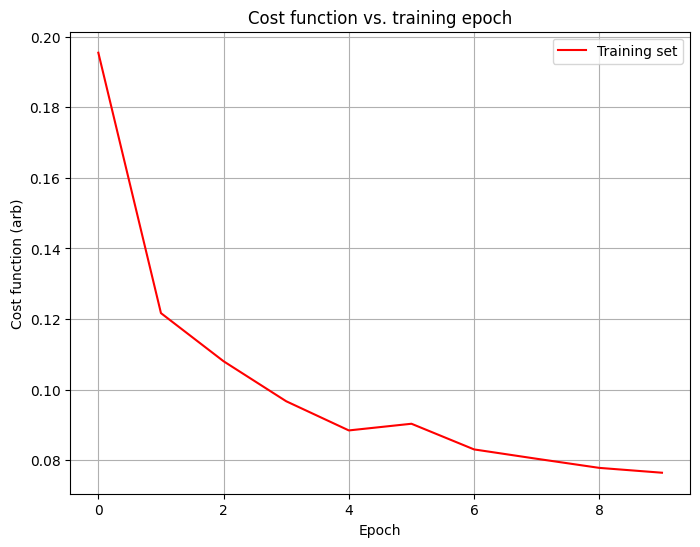

In [267]:
# Hyperparameters for training
learning_rate = 0.05
batch_size = 100
num_epochs = 10

# This will default to creating a model with random weights and biases.
model = NN_Model()

# Train the data and save the average cost function
epochs, costs, models = train_model(num_epochs, batch_size, learning_rate, image_train, label_train, model)

# plot data and the best-fit function on the same graph
fig = plt.figure(figsize=(8,6))
plt.title("Cost function vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Cost function (arb)')
plt.grid(which='both', axis='both')
plt.plot(epochs, costs, 'r-', label="Training set")
plt.legend()
plt.show()

**If everything is working as expected, what should the cost function do as we train the model on more and more epochs?**


Increase the number of epochs we are training for and rerun the code (remember it takes about a second to run an epoch). **What do you notice about the behavior of the cost function as you train for larger number of epochs?**

## Effect of hyperparameters

Rerun the code cell above (for 10 epochs) with the following changes. For each of the changes record the value you set the hyperparameter to and answer the question: **How does changing the hyperparameter impact the training?**

- Decrease the `learning_rate`:
- Increase the `learning_rate`:
- Decrease the `batch_size`:
- Increase the `batch_size`:

**How large can you make the learning rate before the training breaks? What do you think is happening when the training breaks?**


**Return the hyperparameters to values where the model is being trained well, and re-run the code to train the model before continuing.**

## So how well can we identify digits?

Well, the cost function is consistantly going down as we continue to train. That's a good sign, but what does it mean for the percentage of the data we can actually identify? Let's explore that.

We will start by defining a function get a single number that corresponds to the digit being identified by the model.

In [268]:
def get_digit(pred):
  pred_list = pred.tolist()
  return pred_list.index(max(pred_list))



Let's print some images of digits, along with the guesses. Setting the value of `valid` will choose if we should display an example where the model was correct or not. The variable `elem` chooses where we start searching through the data for the next example that meets the condition selected in `valid`.

**Print a few cases where the model is wrong and a few cases where the model is correct. Does it make sense to you that those images are the ones where the model is incorrect? Why or why not?**


The image at 9 is an example of the number 4
The model identified the image as a 4.


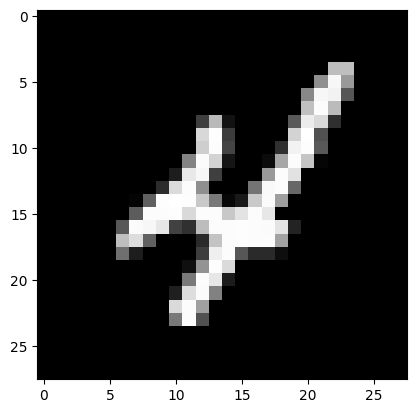

In [285]:
elem = 9 # Element in the training set to display

# if True will show the first example where the model is correct
# if False will show the first example where the model is wrong
valid = True

# Look for the first value of elem that matches the required condition
while ( get_digit(model(torch.tensor(image_train[elem]))) == label_train[elem] ) != valid:
  elem = elem + 1


print(f"The image at {elem} is an example of the number {label_train[elem]}")
digit = get_digit(model(torch.tensor(image_train[elem])))
print(f"The model identified the image as a {digit}.")

# Display the image corresponding to the prediction tensor
image = image_train[elem].reshape((28, 28))
plt.imshow(image, cmap="gray")
plt.show()


We will start by defining a function to calculate the **accuracy** of our model, or what percentage of the data is being properly identified.

In [ ]:
# model: model to evaluate the accuracy of
# data: numpy arrays containing the images to run through the model
# labels: correct labels for our images
def accuracy(model, data, labels):
  xb = torch.tensor(data)
  yb = get_target(labels)
  pred = model(xb)

  num_right = 0
  for i in range(pred.shape[0]):
    guess = get_digit(pred[i])
    if guess == labels[i]:
      num_right = num_right + 1

  return num_right / pred.shape[0]

**What do expect the accuracy of the model to be if we were to evaluate it on a model with random weights?**

After writing down your prediction, check it with the code below.


In [ ]:
rand_acc, cost = accuracy(NN_Model(), image_train, label_train)
print(f"With a model with random weights the accuracy is {rand_acc}")

In our training function, we saved and returned the state of the model after each epoch. Let's evaluate and plot the model accuracy as a function of epoch. **What do you notice about the behavior of the accuracy as you train for larger number of epochs?**

With our best model, our accuracy is 76.45%


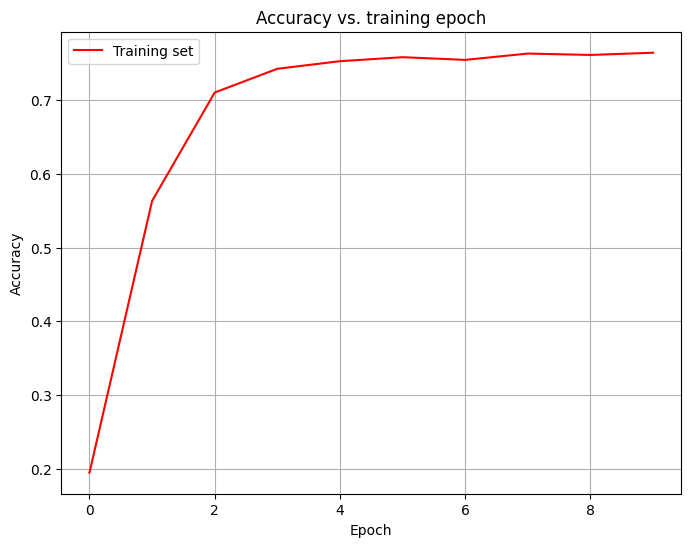

In [263]:
acc = []
for model in models:
  acc.append(accuracy(model, image_train, label_train))

print(f"With our best model, our accuracy is {acc[-1]*100:.2f}%")

fig = plt.figure(figsize=(8,6))
plt.title("Accuracy vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(which='both', axis='both')
plt.plot(epochs, acc, 'r-', label="Training set")
plt.legend()
plt.show()

## What's the best we can do?

It would appear from the behavior of the cost function, and the accuracy, that we just keep getting better as we train longer and longer. And when we are calculating the stats on the training data, that's true, we just keep getting closer and closer to a minimum.

But if our model is to have any use at all, it has to be able to identify *all* digits, not just the exact examples we showed it while training. This is a common problem in machine learning, and to account for it we always split the data we have to train the model up into two groups. First is the training group (what we have been using so far). The second is the **validation group**. This is a set of labeled data that is not used in training. Instead we use it to evaluate how well the model does on *new* data. If you recall, the MINST dataset comes with the data pre-split.

The code below plots the accuracy as a function of model for both the training and validation data sets. **What do you notice about the accuracy as a function of epoch? How is the behavior different for both data sets?**

**What is the best accuracy you would feel comfortable claiming for your model? Why?**

With our best model, our accuracy is 96.95% on the training set and 94.04% on the validation set


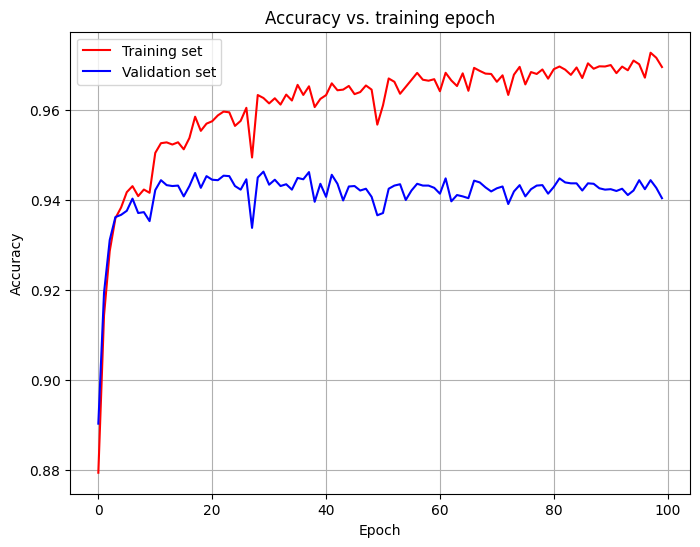

In [255]:
acc_train = []
acc_valid = []
for model in models:
  acc_train.append(accuracy(model, image_train, label_train))
  acc_valid.append(accuracy(model, image_valid, label_valid))

print(f"With our best model, our accuracy is {acc_train[-1]*100:.2f}% on the training set and {acc_valid[-1]*100:.2f}% on the validation set")

fig = plt.figure(figsize=(8,6))
plt.title("Accuracy vs. training epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(which='both', axis='both')
plt.plot(epochs, acc_train, 'r-', label="Training set")
plt.plot(epochs, acc_valid, 'b-', label="Validation set")
plt.legend()
plt.show()